# インポート

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import os
import lightgbm as lgb

#回帰の可視化
#関数の処理で必要なライブラリ
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer

from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

import shap
# import xgboost

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

import warnings
warnings.filterwarnings('ignore')

# pillowをインポート
from PIL import Image
from matplotlib_venn import venn2, venn2_circles
from datetime import datetime

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

In [4]:
%env DATA_ROOT Desktop/副業/SIGNATE/AIQuest/PBL/PBL_AI

env: DATA_ROOT=Desktop/副業/SIGNATE/AIQuest/PBL/PBL_AI


# 各種ディレクトリの定義

In [5]:
dataset_root = os.environ.get('DATA_ROOT', None)
assert dataset_root is not None

input_dir = os.path.join(dataset_root, "inputs")
output_dir = os.path.join(dataset_root, "outputs")
os.makedirs(output_dir, exist_ok=True)

## 内部データ

In [19]:
sales_history_df = pd.read_csv('./inputs/sales_history.csv')
category_names_df = pd.read_csv('./inputs/category_names.csv')
item_categories_df = pd.read_csv('./inputs/item_categories.csv')
test_df = pd.read_csv('./inputs/test.csv')

## 外部データ

In [20]:
syukujitsu_df = pd.read_csv('./inputs/syukujitsu.csv', encoding="shift-jis")
syukujitsu_df.columns = ["日付", "holiday"]
syukujitsu_df["日付"] = pd.to_datetime(syukujitsu_df["日付"])

# 各データを余すことなく結合していく

### category_names

In [21]:
category_names_df.head()

,商品カテゴリID,商品カテゴリ名
0,100,映画 - DVD
1,110,PCゲーム - 通常版
2,120,音楽 - その他
3,130,ゲーム - ゲーム機C
4,140,映画 - ブルーレイ


In [22]:
# 辞書を作る
category_names_dict = category_names_df.set_index('商品カテゴリID').to_dict()['商品カテゴリ名']

In [23]:
# category_names_dict

### item_categories

In [24]:
item_categories_df

,商品ID,商品カテゴリID
0,1000001,100
1,1000002,100
2,1000003,100
3,1000004,100
4,1000005,100
...,...,...
9421,3500072,350
9422,3500073,350
9423,3500074,350
9424,3500075,350


In [12]:
# 辞書を作る
item_categories_dict = item_categories_df.set_index('商品ID').to_dict()['商品カテゴリID']

In [609]:
# item_categories_dict

In [29]:
#辞書を使ってカテゴリを追加
item_categories_df['商品カテゴリ名'] = item_categories_df['商品カテゴリID'].map(category_names_dict)
item_categories_df

,商品ID,商品カテゴリID,商品カテゴリ名
0,1000001,100,映画 - DVD
1,1000002,100,映画 - DVD
2,1000003,100,映画 - DVD
3,1000004,100,映画 - DVD
4,1000005,100,映画 - DVD
...,...,...,...
9421,3500072,350,本 - オーディオブック_タイプB
9422,3500073,350,本 - オーディオブック_タイプB
9423,3500074,350,本 - オーディオブック_タイプB
9424,3500075,350,本 - オーディオブック_タイプB


In [32]:
item_categories_df[['商品ID','商品カテゴリID']] = item_categories_df[['商品ID','商品カテゴリID']].astype(str)

In [34]:
# item_categories_df.to_pickle('./inputs/item_categories_addname')

## 結合

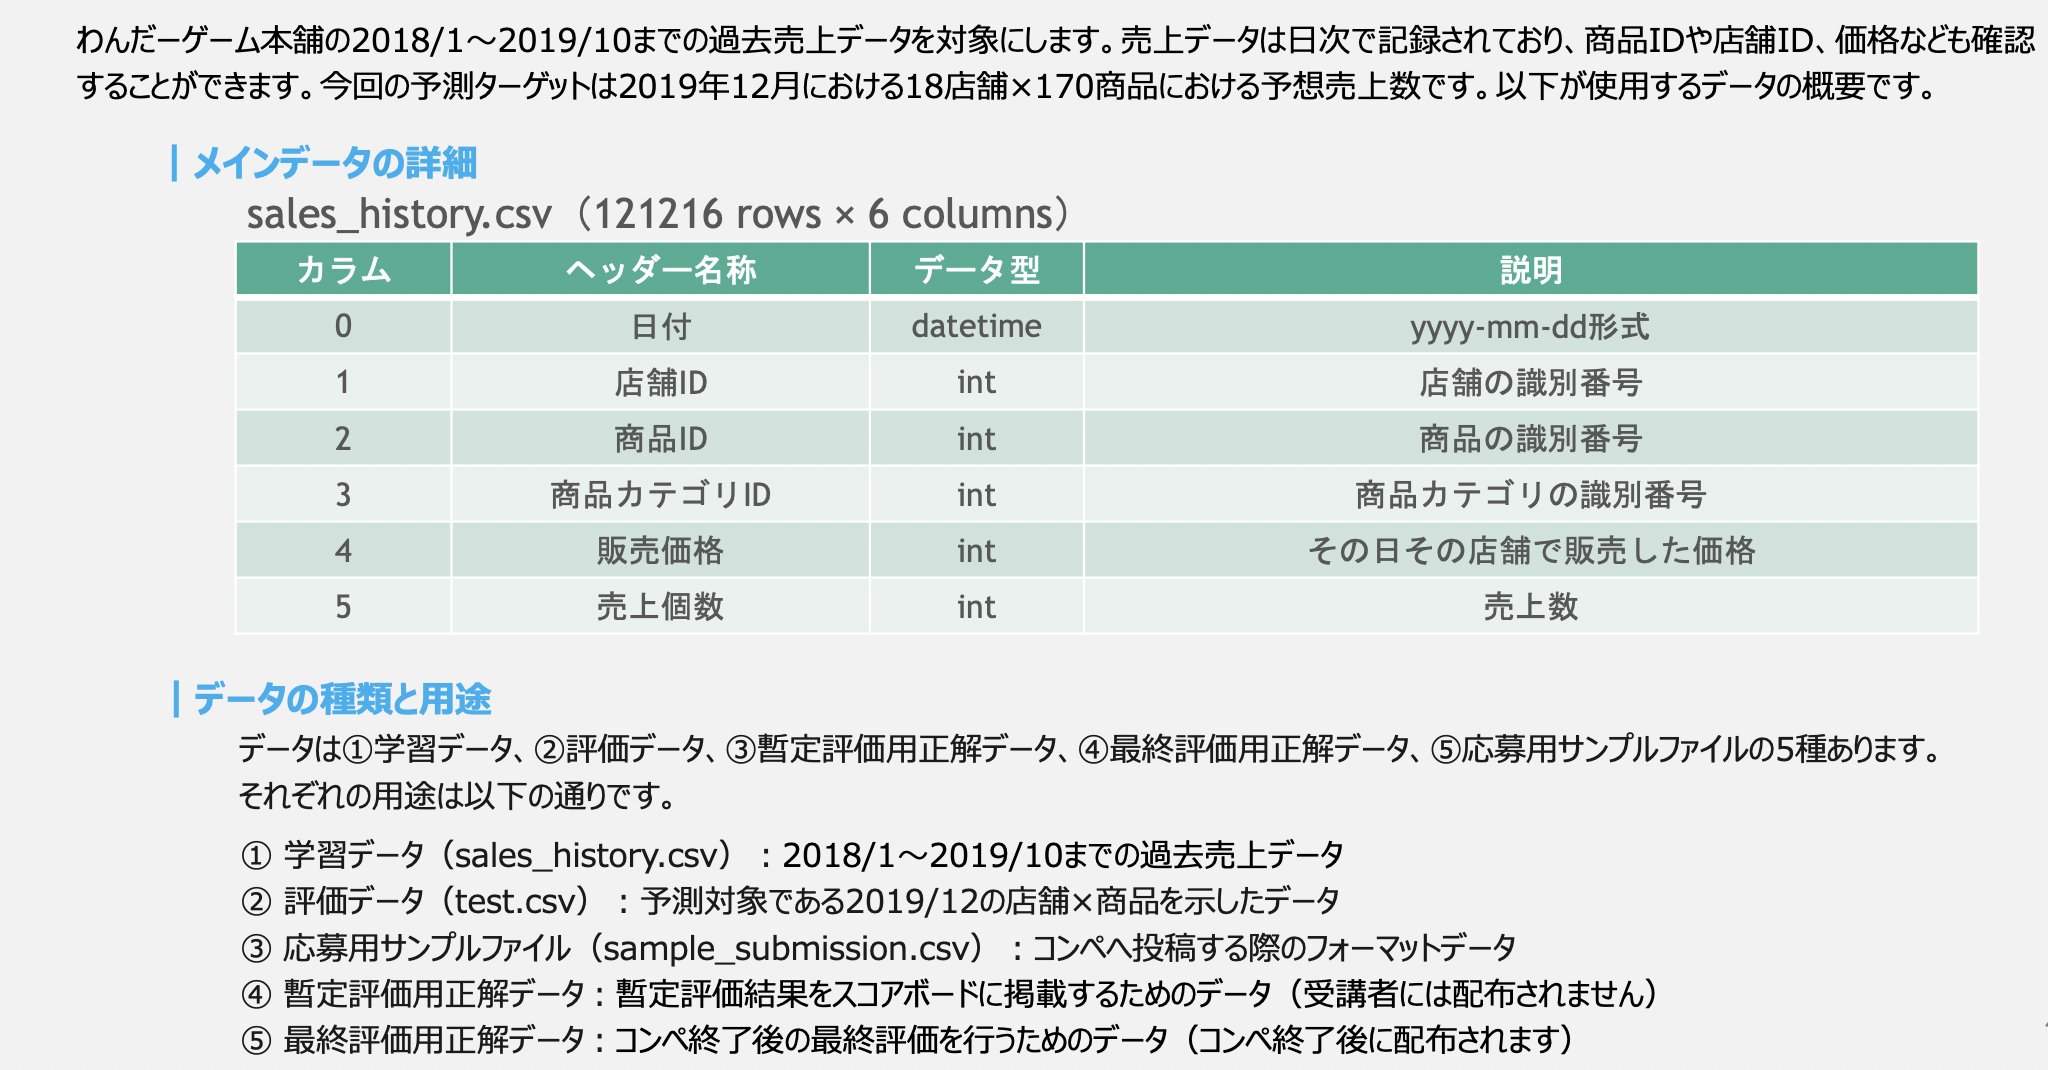

In [610]:
# 画像パス
filename = "./画像/data.png"
# Pillowで開く
im = Image.open(filename)
# 表示
im

# 特徴量追加

In [644]:
df = sales_history_df.copy()

In [645]:
#辞書を使ってカテゴリを追加
df['商品カテゴリ'] = df['商品ID'].map(item_categories_dict)
df['商品カテゴリ名'] = df['商品カテゴリ'].map(category_names_dict)

In [646]:
# df['売り上げ金額'] = df['商品価格'] * sales_history_df['売上個数']
df[['店舗ID', '商品ID']] = df[['店舗ID', '商品ID']].astype(str)

## 日付をdatetime型に変更

In [647]:
df['日付'] = pd.to_datetime(df['日付'])

## 祝日データ

In [648]:
df = pd.merge(df, syukujitsu_df, on="日付", how="left")

In [649]:
df["holiday"].fillna(0, inplace=True)
df.loc[~(df.holiday == 0), "holiday"] = 1
df["holiday"] = df["holiday"].astype(str)

## 日付データ

In [650]:
df[['year_cat', 'month_cat', 'day_cat']] = list(map(lambda text:text.split('-'), df["日付"].astype(str)))

In [651]:
df[['year', 'month', 'day']] = df[['year_cat', 'month_cat', 'day_cat']] .astype(int)

In [652]:
def get_day_of_week_jp(dt):
    w_list = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
    return(w_list[dt.weekday()])

In [653]:
df['weekday_cat'] = df['日付'].apply(lambda x : get_day_of_week_jp(x))
df['weekday'] = df['日付'].apply(lambda x : x.weekday())

## sin, cosへの変換

In [654]:
def encode(df, col):
    # この方法だと場合によって最大値が変化するデータでは正確な値は出ない
    # 例：月の日数が30日や31日の場合がある
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df

In [655]:
df = encode(df, 'month')
df = encode(df, 'weekday')
df = encode(df, 'day')

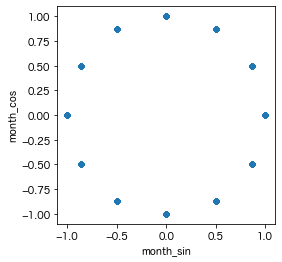

In [660]:
# 例：月の循環性
df.plot.scatter('month_sin', 'month_cos').set_aspect('equal')

## 商品カテゴリー

In [656]:
category = df["商品カテゴリ名"].apply(lambda text : text.split('-'))
category_list = list(category)

In [657]:
df[["商品カテゴリ名_1", '商品カテゴリ名_2']] = category_list

In [658]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1119570 entries, 0 to 1119569
Data columns (total 24 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   日付           1119570 non-null  datetime64[ns]
 1   店舗ID         1119570 non-null  object        
 2   商品ID         1119570 non-null  object        
 3   商品価格         1119570 non-null  int64         
 4   売上個数         1119570 non-null  float64       
 5   商品カテゴリ       1119570 non-null  int64         
 6   商品カテゴリ名      1119570 non-null  object        
 7   holiday      1119570 non-null  object        
 8   year_cat     1119570 non-null  object        
 9   month_cat    1119570 non-null  object        
 10  day_cat      1119570 non-null  object        
 11  year         1119570 non-null  int64         
 12  month        1119570 non-null  int64         
 13  day          1119570 non-null  int64         
 14  weekday_cat  1119570 non-null  object        
 15  weekday      11

In [659]:
df.head()

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリ,商品カテゴリ名,holiday,year_cat,month_cat,day_cat,year,month,day,weekday_cat,weekday,month_cos,month_sin,weekday_cos,weekday_sin,day_cos,day_sin,商品カテゴリ名_1,商品カテゴリ名_2
0,2018-01-01,9,1000001,420,1.0,100,映画 - DVD,1,2018,01,01,2018,1,1,月曜日,0,0.866025,0.5,1.0,0.0,0.97953,0.201299,映画,DVD
1,2018-01-01,6,1000001,420,1.0,100,映画 - DVD,1,2018,01,01,2018,1,1,月曜日,0,0.866025,0.5,1.0,0.0,0.97953,0.201299,映画,DVD
2,2018-01-01,10,1000001,420,1.0,100,映画 - DVD,1,2018,01,01,2018,1,1,月曜日,0,0.866025,0.5,1.0,0.0,0.97953,0.201299,映画,DVD
3,2018-01-01,0,1000017,250,1.0,100,映画 - DVD,1,2018,01,01,2018,1,1,月曜日,0,0.866025,0.5,1.0,0.0,0.97953,0.201299,映画,DVD
4,2018-01-01,1,1000017,250,1.0,100,映画 - DVD,1,2018,01,01,2018,1,1,月曜日,0,0.866025,0.5,1.0,0.0,0.97953,0.201299,映画,DVD


# Drop

## 売り上げ個数がマイナスのものはどんなものか

In [664]:
df = df[df['売上個数'] >= 0]

# 特徴量を追加したデータフレームを保存

In [667]:
# df.to_pickle('./inputs/sales_history_addfeature1.pickle')

# こっからは追加してない

# ラグ特徴量の生成

In [491]:
店舗ID_list = df.店舗ID.unique()
店舗ID_list

array(['9', '6', '10', '0', '1', '13', '8', '2', '15', '14', '5', '7',
       '16', '11', '12', '3', '4', '17'], dtype=object)

In [488]:
商品ID_list = df.商品ID.unique()
商品ID_list

array(['1000001', '1000017', '1000018', ..., '1700230', '2100176',
       '2400101'], dtype=object)

In [492]:
df[(df.商品ID == 商品ID_list[0]) & (df.店舗ID == 店舗ID_list[0])]

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリ,商品カテゴリ名,holiday,year_cat,month_cat,day_cat,year,month,day,weekday_cat,weekday,商品カテゴリ名_1,商品カテゴリ名_2
0,2018-01-01,9,1000001,420,1.0,100,映画 - DVD,1,2018,01,01,2018,1,1,月曜日,0,映画,DVD
865,2018-01-02,9,1000001,420,1.0,100,映画 - DVD,0,2018,01,02,2018,1,2,火曜日,1,映画,DVD
30777,2018-01-14,9,1000001,420,1.0,100,映画 - DVD,0,2018,01,14,2018,1,14,日曜日,6,映画,DVD
49239,2018-01-25,9,1000001,420,1.0,100,映画 - DVD,0,2018,01,25,2018,1,25,木曜日,3,映画,DVD
60632,2018-01-31,9,1000001,420,1.0,100,映画 - DVD,0,2018,01,31,2018,1,31,水曜日,2,映画,DVD
89462,2018-02-15,9,1000001,420,1.0,100,映画 - DVD,0,2018,02,15,2018,2,15,木曜日,3,映画,DVD
161624,2018-03-20,9,1000001,420,1.0,100,映画 - DVD,0,2018,03,20,2018,3,20,火曜日,1,映画,DVD
215503,2018-04-18,9,1000001,420,1.0,100,映画 - DVD,0,2018,04,18,2018,4,18,水曜日,2,映画,DVD
335230,2018-06-27,9,1000001,420,1.0,100,映画 - DVD,0,2018,06,27,2018,6,27,水曜日,2,映画,DVD
363026,2018-07-13,9,1000001,420,1.0,100,映画 - DVD,0,2018,07,13,2018,7,13,金曜日,4,映画,DVD


## 1日前

In [470]:
df['1day_ago売上個数'] = df['売上個数'].shift(1)

## 1週間前

## 1年前

## 集約関数

In [451]:
def get_static(group_column_name, agg_column_name, train):
    table = train.groupby(group_column_name).agg({agg_column_name: ["sum", "mean", "median", "count", "max"]})
    table.reset_index(inplace=True)
    table.columns = ["".join(c) for c in table.columns]
    return table

### 商品ID-売り上げ金額

どの商品が数多く売れているががわかる

In [452]:
get_static("商品ID","売上個数", df).sort_values("売上個数sum", ascending=False)

,商品ID,売上個数sum,売上個数mean,売上個数median,売上個数count,売上個数max
3001,1100375,8714.0,1.879638,1.0,4636,37.0
4654,1300239,8397.0,1.849967,1.0,4539,107.0
2664,1100038,6705.0,1.419949,1.0,4722,44.0
2930,1100304,6681.0,1.992544,1.0,3353,88.0
6724,1900090,5627.0,1.327749,1.0,4238,8.0
...,...,...,...,...,...,...
4741,1300326,1.0,1.000000,1.0,1,1.0
9039,3500073,1.0,1.000000,1.0,1,1.0
6630,1800260,0.0,0.000000,0.0,2,1.0
6776,1900142,0.0,0.000000,0.0,2,1.0


### 店舗ID-売り上げ個数

どの店舗が売り上げているががわかる

In [453]:
get_static("店舗ID","売上個数", df).sort_values("売上個数sum", ascending=False)

,店舗ID,売上個数sum,売上個数mean,売上個数median,売上個数count,売上個数max
5,13,125420.0,1.175071,1.0,106734,88.0
15,7,124894.0,1.144378,1.0,109137,77.0
0,0,107953.0,1.172026,1.0,92108,51.0
2,10,102815.0,1.155069,1.0,89012,44.0
14,6,102087.0,1.134464,1.0,89987,107.0
11,3,87529.0,1.107724,1.0,79017,30.0
17,9,67352.0,1.220034,1.0,55205,151.0
12,4,64902.0,1.104847,1.0,58743,100.0
10,2,56431.0,1.088540,1.0,51841,32.0
9,17,56253.0,1.077004,1.0,52231,36.0


In [458]:
df.groupby('日付').agg({'商品ID': ["count"]})

,商品ID
,count
日付,
2018-01-01,864
2018-01-02,3523
2018-01-03,3365
2018-01-04,3015
2018-01-05,2990
2018-01-06,2727
2018-01-07,2401
2018-01-08,2314


### 日付-個数

In [456]:
get_static("日付","売上個数", df).sort_values("売上個数sum", ascending=False)

,日付,売上個数sum,売上個数mean,売上個数median,売上個数count,売上個数max
361,2018-12-28,6469.0,1.272924,1.0,5082,14.0
362,2018-12-29,6359.0,1.245642,1.0,5105,13.0
363,2018-12-30,6282.0,1.245440,1.0,5044,11.0
364,2018-12-31,5033.0,1.218644,1.0,4130,12.0
53,2018-02-23,4922.0,1.188028,1.0,4143,9.0
354,2018-12-21,4329.0,1.189613,1.0,3639,7.0
417,2019-02-22,4267.0,1.212216,1.0,3520,13.0
1,2018-01-02,4123.0,1.170309,1.0,3523,17.0
52,2018-02-22,4078.0,1.152954,1.0,3537,15.0
74,2018-03-16,4020.0,1.327171,1.0,3029,23.0


### 曜日

In [399]:
get_static("weekday_cat", df).sort_values("売り上げ金額sum", ascending=False)

,weekday_cat,売り上げ金額sum,売り上げ金額mean,売り上げ金額median,売り上げ金額count,売り上げ金額max
6,金曜日,281917320.0,1229.072694,680.0,229374,113360.0
0,土曜日,232938650.0,1193.321021,680.0,195202,137700.0
3,木曜日,215677910.0,1280.915025,680.0,168378,523570.0
4,水曜日,173046540.0,1216.547201,680.0,142244,123390.0
2,月曜日,165346640.0,1293.448065,680.0,127834,274860.0
5,火曜日,161791530.0,1223.607714,680.0,132225,292500.0
1,日曜日,147205090.0,1184.148802,680.0,124313,118320.0


In [401]:
# g = sns.catplot(
#     data=df.sort_values("売り上げ金額sum", ascending=False),
#     x="店舗ID",
#     y="売り上げ金額",
#     kind="box"
# )
# g.fig.set_figheight(10)
# g.fig.set_figwidth(20)

# 時系列プロット

In [404]:
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [406]:
unique_columns = ['商品ID', '店舗ID']

In [407]:
np.array(df[unique_columns].dropna(axis=0)).T

array([['1000001', '1000001', '1000001', ..., '3400012', '3500001',
        '3500004'],
       ['9', '6', '10', ..., '7', '4', '13']], dtype=object)

In [ ]:
data_train = np.array(df[unique_columns].dropna(axis=0)).T
X_train = to_time_series_dataset(data_train)

In [405]:
# 数字のカラム
number_columns = df.columns[df.columns.str.contains("[0-9]")]
number_columns

Index(['商品カテゴリ名_1', '商品カテゴリ名_2'], dtype='object')

In [ ]:
# SUMの作成
df["SUM"] = df.loc[:,number_columns].sum(axis=1)

In [402]:
df.head()

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリ,商品カテゴリ名,売り上げ金額,holiday,year_cat,month_cat,day_cat,year,month,day,weekday_cat,weekday,商品カテゴリ名_1,商品カテゴリ名_2
0,2018-01-01,9,1000001,420,1.0,100,映画 - DVD,420.0,1,2018,01,01,2018,1,1,月曜日,0,映画,DVD
1,2018-01-01,6,1000001,420,1.0,100,映画 - DVD,420.0,1,2018,01,01,2018,1,1,月曜日,0,映画,DVD
2,2018-01-01,10,1000001,420,1.0,100,映画 - DVD,420.0,1,2018,01,01,2018,1,1,月曜日,0,映画,DVD
3,2018-01-01,0,1000017,250,1.0,100,映画 - DVD,250.0,1,2018,01,01,2018,1,1,月曜日,0,映画,DVD
4,2018-01-01,1,1000017,250,1.0,100,映画 - DVD,250.0,1,2018,01,01,2018,1,1,月曜日,0,映画,DVD


# plotly.express

In [99]:
import plotly.express as px

In [110]:
sales_history_df_1100038

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリ,商品カテゴリ名
291,2018-01-01,9,1100038,1020,1.0,110,PCゲーム - 通常版
292,2018-01-01,15,1100038,1020,1.0,110,PCゲーム - 通常版
293,2018-01-01,14,1100038,1020,2.0,110,PCゲーム - 通常版
294,2018-01-01,0,1100038,1020,1.0,110,PCゲーム - 通常版
295,2018-01-01,10,1100038,1020,3.0,110,PCゲーム - 通常版
...,...,...,...,...,...,...,...
1114897,2019-10-27,8,1100038,1020,1.0,110,PCゲーム - 通常版
1114898,2019-10-27,6,1100038,1020,1.0,110,PCゲーム - 通常版
1117575,2019-10-30,12,1100038,1020,1.0,110,PCゲーム - 通常版
1117576,2019-10-30,1,1100038,1020,1.0,110,PCゲーム - 通常版


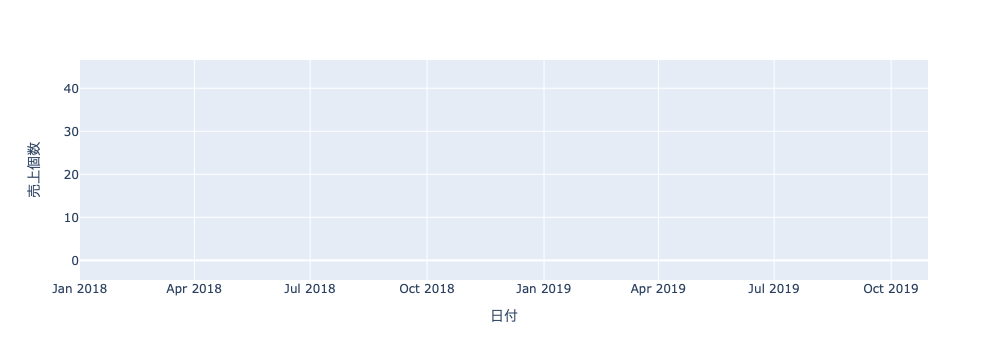

In [111]:
sales_history_df_1100038 = sales_history_df[sales_history_df['商品ID'] == 1100038]
px.line(sales_history_df_1100038, x='日付', y="売上個数")

### treemap

In [126]:
# trade_hist_side = sales_history_df
# trade_hist_side['board'] = 'JP_TOTAL'
# px.treemap(trade_hist_side, path=['board', '店舗ID', '日付'], values="売上個数")

In [ ]:
syukujitsu_df.columns = ["date", "holiday"]
syukujitsu_df["date"] = pd.to_datetime(syukujitsu_df["date"])
syukujitsu_df
del syukujitsu
df["holiday"].fillna(0, inplace=True)
df.loc[~(df.holiday == 0), "holiday"] = 1
df["holiday"] = df["holiday"].astype(int)